In [1]:
%matplotlib widget
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")
from schemes.weno import get_left_flux,get_right_flux,get_Max_Phase_Speed
from schemes.weno import get_stencil
import sediment_transport.sed_trans as sedtrans
import morph_geom_lib as mgl

import models.shallow_depth_morph_models as sdmodels
from models.shallow_water_solver import shallow_water_solver
from schemes.avalanche_scheme import *

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

rc('animation', html='html5')

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['default'])

Grid dx = 1.0
Grid nx = 300


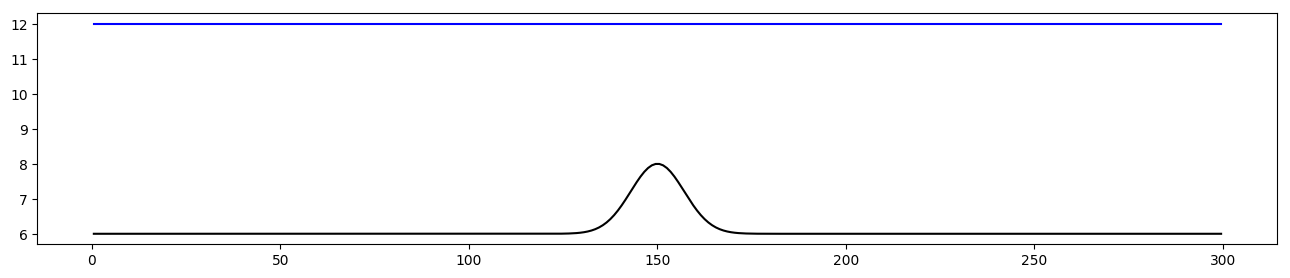

In [2]:
# Set up the constants

a=0.001
b=3.0
Q=10.0
nP=0.4
xcentre = 150.  # Centre of hum
h0 = 6.0        # Height of the dune
s= 12.0            # Datum
beta = 0.01

nx=300
x = pyclaw.Dimension(0.0,300.0,nx,name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain,1)
xc = state.grid.x.centers
dx = state.grid.delta[0]
print('Grid dx = {0}'.format(dx))
print('Grid nx = {0}'.format(len(xc)))

# Set up the bathymetry
z = np.zeros(nx)

# Eq 66
z = np.array([(h0 + 2.0*math.exp(-beta*(xp-xcentre)**2)) for xp in xc])
zc = z.copy()
z0 = zc.copy() 
fig = plt.figure(figsize=(16, 3))
surf = np.ones(nx) * s
plt.plot(xc, surf, 'b')
plt.plot(xc, zc,'k')

In [1]:
fig = plt.figure(figsize=(13, 3))
from schemes.weno import get_exact_solution
x_600, z_a600 = get_exact_solution(z0,xc, 0.4,s,a,b,10.,600.)
x_2000, z_a2000 = get_exact_solution(z0,xc, 0.4,s,a,b,10.,2000.)
x_6000, z_a6000 = get_exact_solution(z0,xc, 0.4,s,a,b,10.,6000.)
np.shape(x_600),np.shape(z_a600)

plt.plot(xc,z0, label='t=0', color='k')
plt.plot(xc, surf, 'b')
plt.plot(x_600, z_a600, 'g-.', label='Extact t=600',)
plt.plot(x_2000, z_a2000,'b-.', label='Exact t=2000')
plt.plot(x_6000, z_a6000,'r-.', label='Exact t=6000')

plt.xlabel('Station (m)')

plt.legend()


NameError: name 'plt' is not defined

## Updated Morpho Model

In [31]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 6000 # Runtime in seconds
dt = 0.1 # Time step size (s)
extractionTime = 100.
nt = int(simTime/dt)  # Number of time st


import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

run_name = 'dune_5_q_{0}_h_{1}_TVD_WENO'.format(Q,'12')

model = sdmodels.ModifiedShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
x0 = xc.copy()
zc = z0.copy()
nx = len(xc)


model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(Q, 12.)
model.setup_chezy_hydro_model(0.00001, 0)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = False, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)
#model.set_scale_factor(1)
#model.use_modifier()
#model.use_periodic_reattachment()

model.set_grass_parameters(a,b)

zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h

        


 Starting simulation....
Number of time steps: 1000.0 mins
Grid dx = 1.0
Grid nx = 300
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 1.6666666666666667 mins - uavg: 1.7173347523898679 - Elevation 11.99568561949379
Courant number: max 0.6206438516906759, mean-0.00032217697045116715
Time step: 3.3333333333333335 mins - uavg: 1.7207210087420883 - Elevation 11.995825350867527
Courant number: max 0.6684178303794921, mean0.0031992953379416235
Time step: 5.0 mins - uavg: 1.7224687776118692 - Elevation 11.996069759273253
Courant number: max 0.05396898608896331, mean-0.005342993970367181
Time step: 6.666666666666667 mins - uavg: 1.7221617215347222 - Elevation 11.99636404789179
Courant number: max 0.7619749024608736, mean0.003512814836989412
Time step: 8.333333333333334 mins - uavg: 1.7200722893072529 - Elevation 11.99637969282211
Courant number: max 0.11899981239150932, mean0.00095490258

In [33]:
verts = model._verts
np.save('_output/{0}_verts.npy'.format('gaussian', verts),verts)
verts = np.load('_output/{0}_verts.npy'.format('gaussian'))

In [34]:
verts.shape

(59, 300, 6)

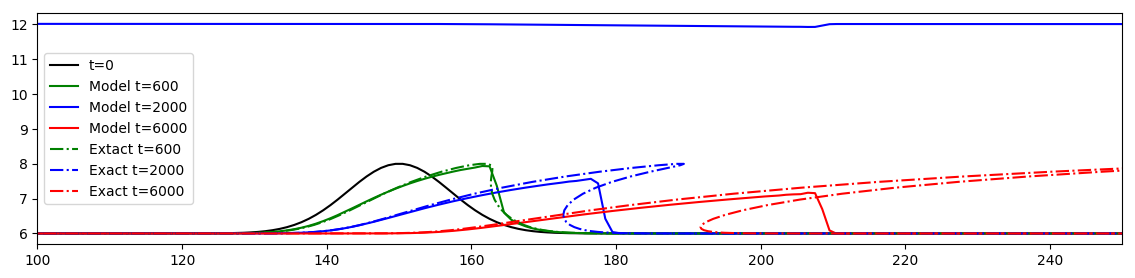

In [35]:
fig = plt.figure(figsize=(14, 3))
plt.plot(xc, surf, 'b')
plt.xlim(100,250)

z600 = verts[4,:,1]
z2000= verts[18,:,1]


plt.plot(xc,z0, label='t=0', color='k')
plt.plot(xc, z600,label='Model t=600',color='g')
plt.plot(xc, z2000,label='Model t=2000',color='b')
plt.plot(xc, zc,label='Model t=6000',color='r')


plt.plot(x_600, z_a600, 'g-.', label='Extact t=600',)
plt.plot(x_2000, z_a2000,'b-.', label='Exact t=2000')
plt.plot(x_6000, z_a6000,'r-.', label='Exact t=6000')
plt.legend()

In [4]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 6000 # Runtime in seconds
dt = 0.1 # Time step size (s)
extractionTime = 100.
nt = int(simTime/dt)  # Number of time st


import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

run_name = 'gaussian_maccormack'.format('32m','357mm')

model = sdmodels.ModifiedShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
x0 = xc.copy()
zc = z0.copy()
nx = len(xc)


model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(Q, 12.)
model.setup_chezy_hydro_model(0.00001, 0)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
morph_model = sdmodels.MacCormackModel()
#morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = False, 
                           useSmoother = True, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)
#model.set_scale_factor(1)
#model.use_modifier()
#model.use_periodic_reattachment()

model.set_grass_parameters(a,b)

zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h


 Starting simulation....
Number of time steps: 1000.0 mins
Grid dx = 1.0
Grid nx = 300
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 1.6666666666666667 mins - uavg: 1.7129914423594066 - Elevation 11.995861253791094
Courant number: max 0.2568677757317653, mean-0.03199955452881431
Time step: 3.3333333333333335 mins - uavg: 1.7123573934799765 - Elevation 11.996069622968877
Courant number: max 0.1399472073329737, mean-0.006575026788724186
Time step: 5.0 mins - uavg: 1.7118537046707047 - Elevation 11.996231470851368
Courant number: max 0.18629908328549818, mean-0.0004246119027359285
Time step: 6.666666666666667 mins - uavg: 1.711433286494474 - Elevation 11.996364958363454
Courant number: max 0.25875259607589174, mean0.0011731637381907519
Time step: 8.333333333333334 mins - uavg: 1.7110712364846492 - Elevation 11.996479063290451
Courant number: max 0.19967873794813762, mean0.000679388

In [32]:
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)
verts = np.load('_output/{0}_verts.npy'.format('gaussian'))

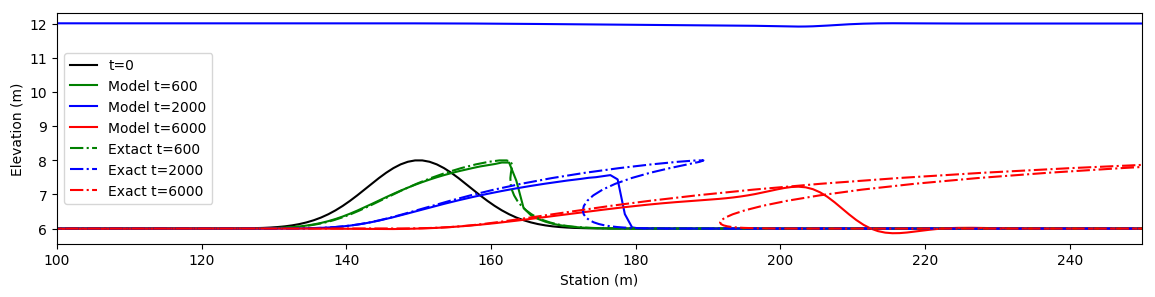

In [25]:
fig = plt.figure(figsize=(14, 3))
plt.plot(xc, surf, 'b')
plt.xlim(100,250)

z600 = verts[4,:,1]
z2000= verts[18,:,1]


plt.plot(xc,z0, label='t=0', color='k')
plt.plot(xc, z600,label='Model t=600',color='g')
plt.plot(xc, z2000,label='Model t=2000',color='b')
plt.plot(xc, zc,label='Model t=6000',color='r')

plt.ylabel('Elevation (m)')
plt.xlabel('Station (m)')

plt.plot(x_600, z_a600, 'g-.', label='Extact t=600',)
plt.plot(x_2000, z_a2000,'b-.', label='Exact t=2000')
plt.plot(x_6000, z_a6000,'r-.', label='Exact t=6000')
plt.legend()

Grid dx = 1.0
Grid nx = 300
57.20592950005084


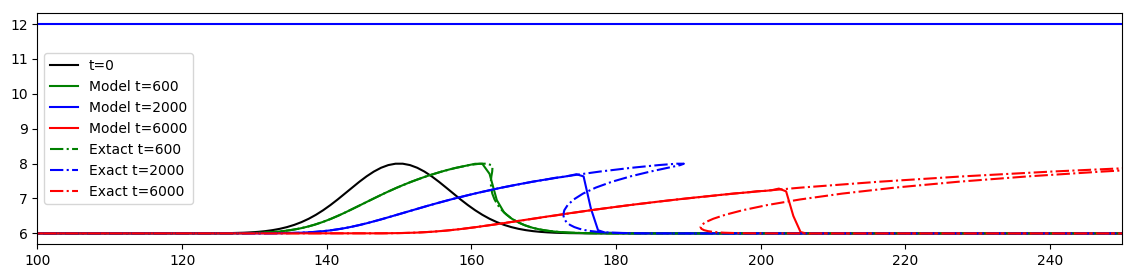

In [28]:
#--------------------------------
# Set up the constants
#--------------------------------
a=0.001
b=3.0
Q=10.0
nP=0.4
xcentre = 150.  # Centre of hum
h0 = 6.0        # Height of the dune
s= 12.0            # Datum
beta = 0.01

#--------------------------------
# Set up the domain, BCs and ICs
#--------------------------------

nx=300
x = pyclaw.Dimension(0.0,300.0,nx,name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain,1)
xc = state.grid.x.centers
dx = state.grid.delta[0]
print('Grid dx = {0}'.format(dx))
print('Grid nx = {0}'.format(len(xc)))

# Set up the bathymetry
z = np.zeros(nx)
# Eq 66
z = np.array([(h0 + 2.0*math.exp(-beta*(xp-xcentre)**2)) for xp in xc])
zc = z.copy()

# Eq 59
h = np.zeros(nx)
h = s - zc
# Eq 58
u = np.zeros(nx)
u = Q/h
# Eq 57
qbedload = np.zeros(nx)
roe_speed = np.zeros(nx)
qbedload = a*u**b

flux = np.zeros(nx)

surf = np.ones(nx) * s

#--------------------------------
# Run the model
#--------------------------------

simTime = 6000. # Runtime
dt = 1 # Time step size (s)
nt = int(simTime/dt)  # Number of time steps


z0 = zc.copy() 
z600 = zc.copy() 
z2000 = zc.copy()
verts = []

extractionInterval = 100.
tsteps=[]

from timeit import default_timer as timer

start = timer()

# Each time-step
for n in range(1,nt):  
    zn = zc.copy() 
    # Now iterate over the domain
    for i in range(0,nx): 
        #i=2
        # xloc = xc[i-(k-1):i+k]
        #xloc = get_stencil(xc,i-(k-1),i+k+1) #i+k-1-(i-(k-1)-1) = 2k -1 
        zloc = get_stencil(zn,i-2,i+4)
        #print xloc
        #raise ValueError()
        
        # Since k=3
        # stencil is i-2 to i+2 
        qloc = get_stencil(qbedload,i-2,i+4)
        if len(qloc) != 6:
            raise ValueError('Stencil is incorrect')
 
        #f_left,f_right = ENO(xloc,qloc,k)
        #f_left,f_right = WENO(xloc,qloc,k)
        
        
        #upwind flux
        # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
        # this is the evaluation of the left and right based fluxes. Eq. 18 and 19
        
        if (zloc[3]-zloc[2]) == 0.0:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2]) )
        else:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )
        
        if roe_speed[i] >= 0.0:
            flux[i] = get_left_flux(qloc)
        else:
            flux[i] = get_right_flux(qloc)
        
    # Need the sign of the phase speed
    # Need to check this out

    for i in range(0,nx): #i=2       
        floc = get_stencil(flux,i-1,i+1)
        # This is essentially eq. 8. 
        zc[i] = zn[i]-(1./(1.-nP))*(dt/(1.0*dx))*(floc[1]-floc[0])
    
        
    # Update the flow depth, velocity and bedload
    h = s - zc
    u = Q/h
    qbedload = a*u**b

    if n*dt==600:
        z600 = zc.copy()
    if n*dt==2000:
        z2000 = zc.copy()
        
end = timer()
print(end - start) # Time in seconds, e.g. 5.38091952400282

fig = plt.figure(figsize=(14, 3))
plt.plot(xc, surf, 'b')
plt.xlim(100,250)
plt.plot(xc,z0, label='t=0', color='k')
plt.plot(xc, z600,label='Model t=600',color='g')
plt.plot(xc, z2000,label='Model t=2000',color='b')
plt.plot(xc, zc,label='Model t=6000',color='r')
plt.plot(x_600, z_a600, 'g-.', label='Extact t=600',)
plt.plot(x_2000, z_a2000,'b-.', label='Exact t=2000')
plt.plot(x_6000, z_a6000,'r-.', label='Exact t=6000')
plt.legend()

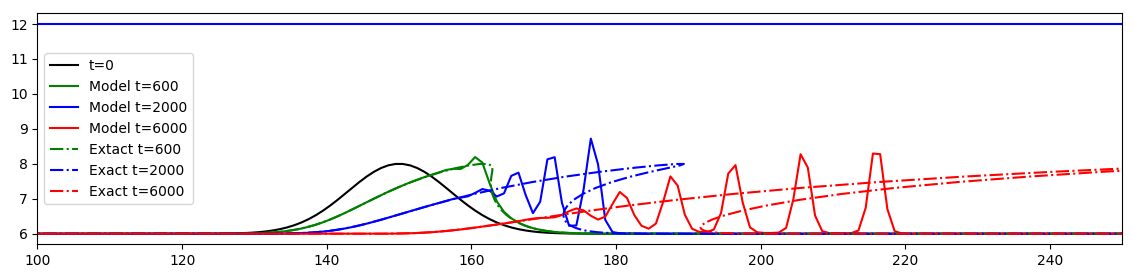

In [25]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 6000 # Runtime in seconds
dt = 0.25 # Time step size (s)
extractionInterval = 60.*1
nt = int(simTime/dt)  # Number of time st

qbedload = np.zeros(len(xc))
cntr = 0

zc = z0.copy()
#--------------------------------
#  Run the model
#--------------------------------
time_series = collections.OrderedDict()
time = 0
for n in range(1,nt):  
    zn = zc.copy() 
    zhatn = zc.copy() 
    alpha = np.zeros(nx)
        
    # Need the sign of the phase speed
    # Need to check this out
      
    for i in range(0,nx): #i=2       
        qloc = get_stencil(qbedload,i-1,i+2)  
        zhatn[i] = zn[i]-(1./(1.-nP))*dt/(dx)*(qloc[1] - qloc[0])
        
    # Update the flow depth, velocity and bedload
    h = s - zhatn
    u = Q/h
    qbedload = a*u**b
        
    for i in range(0,nx): #i=2       
        qloc = get_stencil(qbedload,i-1,i+2)  
        zc[i] = 0.5*(zhatn[i]+zn[i]) - (1/(1.-nP))*dt/(dx*2.)*(qloc[2] - qloc[1])
        
    
    bed_max_delta = np.max(np.abs(zn - zc))
    

        
    slope = np.gradient(zc,dx)
    
    # Update the flow depth, velocity and bedload
    h = s - zc
    u = Q/h
    qbedload = a*u**b
        
    if n*dt==600:
        z600 = zc.copy()
    if n*dt==2000:
        z2000 = zc.copy()
        

fig = plt.figure(figsize=(14, 3))
plt.plot(xc, surf, 'b')
plt.xlim(100,250)
plt.plot(xc,z0, label='t=0', color='k')
plt.plot(xc, z600,label='Model t=600',color='g')
plt.plot(xc, z2000,label='Model t=2000',color='b')
plt.plot(xc, zc,label='Model t=6000',color='r')
plt.plot(x_600, z_a600, 'g-.', label='Extact t=600',)
plt.plot(x_2000, z_a2000,'b-.', label='Exact t=2000')
plt.plot(x_6000, z_a6000,'r-.', label='Exact t=6000')
plt.legend()

Grid dx = 1.0
Grid nx = 300
Time: 157.6916020999779 seconds


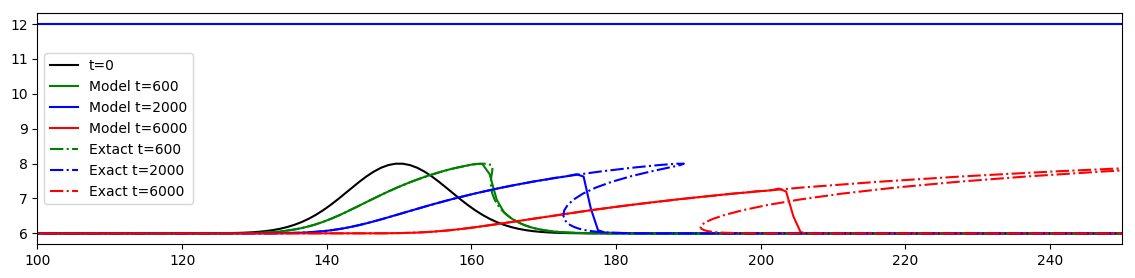

In [27]:
#--------------------------------
# Set up the constants
#--------------------------------
a=0.001
b=3.0
Q=10.0
nP=0.4
xcentre = 150.  # Centre of hum
h0 = 6.0        # Height of the dune
s= 12.0            # Datum
beta = 0.01

#--------------------------------
# Set up the domain, BCs and ICs
#--------------------------------

nx=300
x = pyclaw.Dimension(0.0,300.0,nx,name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain,1)
xc = state.grid.x.centers
dx = state.grid.delta[0]
print('Grid dx = {0}'.format(dx))
print('Grid nx = {0}'.format(len(xc)))

# Set up the bathymetry
z = np.zeros(nx)
# Eq 66
z = np.array([(h0 + 2.0*math.exp(-beta*(xp-xcentre)**2)) for xp in xc])
zc = z.copy()

# Eq 59
h = np.zeros(nx)
h = s - zc
# Eq 58
u = np.zeros(nx)
u = Q/h
# Eq 57
qbedload = np.zeros(nx)
roe_speed = np.zeros(nx)
qbedload = a*u**b

flux = np.zeros(nx)

surf = np.ones(nx) * s

#--------------------------------
# Run the model
#--------------------------------

simTime = 6000. # Runtime
dt = 1 # Time step size (s)
nt = int(simTime/dt)  # Number of time steps


z0 = zc.copy() 
z600 = zc.copy() 
z2000 = zc.copy()
verts = []

extractionInterval = 100.
tsteps=[]

from timeit import default_timer as timer

start = timer()
# ...


# Each time-step
for n in range(1,nt):  
    zn = zc.copy() 
    znp1  = zc.copy() 
    znp12  = zc.copy() 
    znp2  = zc.copy() 
    znp32  = zc.copy() 
    
    ## Step 1
    for i in range(0,nx): 
        zloc = get_stencil(zn,i-2,i+4)
        qloc = get_stencil(qbedload,i-2,i+4)
        #upwind flux
        # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
        # this is the evaluation of the left and right based fluxes. Eq. 18 and 19
        
        if (zloc[3]-zloc[2]) == 0.0:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2]) )
        else:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )
        
        if roe_speed[i] >= 0.0:
            flux[i] = get_left_flux(qloc)
        else:
            flux[i] = get_right_flux(qloc)

    for i in range(0,nx): #i=2       
        floc = get_stencil(flux,i-1,i+1)
        # This is essentially eq. 8. 
        znp1[i] = zn[i]-(1./(1.-nP))*(dt/(1.0*dx))*(floc[1]-floc[0])
        
    # Update the flow depth, velocity and bedload
    h = s - znp1
    u = Q/h
    qbedload = a*u**b
    
    # -------------------------
    # Step 2
    # -------------------------
    for i in range(0,nx): 
        zloc = get_stencil(znp1,i-2,i+4)
        qloc = get_stencil(qbedload,i-2,i+4)
        #upwind flux
        # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
        # this is the evaluation of the left and right based fluxes. Eq. 18 and 19
        
        if (zloc[3]-zloc[2]) == 0.0:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2]) )
        else:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )
        
        if roe_speed[i] >= 0.0:
            flux[i] = get_left_flux(qloc)
        else:
            flux[i] = get_right_flux(qloc)

    for i in range(0,nx): #i=2       
        floc = get_stencil(flux,i-1,i+1)
        # This is essentially eq. 8. 
        znp2[i] = znp1[i]-(1./(1.-nP))*(dt/(1.0*dx))*(floc[1]-floc[0])
        
    # -------------------------
    # Step 3
    # -------------------------
    znp12 = 0.75*zn + 0.25*znp2
    
    # Update the flow depth, velocity and bedload
    h = s - znp12
    u = Q/h
    qbedload = a*u**b
        
    
    # -------------------------
    # Step 4
    # -------------------------
    for i in range(0,nx): 
        zloc = get_stencil(znp12,i-2,i+4)
        qloc = get_stencil(qbedload,i-2,i+4)
        #upwind flux
        # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
        # this is the evaluation of the left and right based fluxes. Eq. 18 and 19
        
        if (zloc[3]-zloc[2]) == 0.0:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2]) )
        else:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )
        
        if roe_speed[i] >= 0.0:
            flux[i] = get_left_flux(qloc)
        else:
            flux[i] = get_right_flux(qloc)

    for i in range(0,nx): #i=2       
        floc = get_stencil(flux,i-1,i+1)
        # This is essentially eq. 8. 
        znp32[i] = znp12[i]-(1./(1.-nP))*(dt/(1.0*dx))*(floc[1]-floc[0])
        
    # -------------------------
    # Step 5
    # -------------------------
    zc = (1./3.)*zn + (2./3.)*znp32
        
    # Update the flow depth, velocity and bedload
    h = s - zc
    u = Q/h
    qbedload = a*u**b

    if n*dt==600:
        z600 = zc.copy()
    if n*dt==2000:
        z2000 = zc.copy()

end = timer()
print('Time: {0} seconds'.format(end - start)) # Time in seconds, e.g. 5.38091952400282

fig = plt.figure(figsize=(14, 3))
plt.plot(xc, surf, 'b')
plt.xlim(100,250)
plt.plot(xc,z0, label='t=0', color='k')
plt.plot(xc, z600,label='Model t=600',color='g')
plt.plot(xc, z2000,label='Model t=2000',color='b')
plt.plot(xc, zc,label='Model t=6000',color='r')
plt.plot(x_600, z_a600, 'g-.', label='Extact t=600',)
plt.plot(x_2000, z_a2000,'b-.', label='Exact t=2000')
plt.plot(x_6000, z_a6000,'r-.', label='Exact t=6000')
plt.legend()

In [7]:
get_Max_Phase_Speed(qbedload,zc,nP)*dt/dx

0.00492655828485196